In [10]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import numpy as np
import os
import sys
from subprocess import call
import warnings
import argparse
import seaborn as sns
from dsa_analysis import load_config
import torch
import multiprocessing
from src.toolkit import pipeline
from src.dsa_optimization import dsa_computation
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Taking order into account

In [11]:
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        if file.endswith("ordered.csv"):
            # split the name of the file to get the parameters
            parameters = file.split("_")
            n_delay = int(parameters[1])
            delay_interval = int(parameters[2].split(".")[0])
            df = pd.read_csv(os.path.join(path, file))
            df["n_delay"] = n_delay
            df["delay_interval"] = delay_interval
            data.append(df)
data = pd.concat(data)
data.rename(columns={"number of shared elements":"number_of_shared_elements"}, inplace=True)
data_all = data.dropna()# plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
data = data_all.groupby(['n_delay', 'delay_interval','number_of_shared_elements'])["similarity"].mean().reset_index()
groups = data.groupby(['n_delay', 'delay_interval'])

### Plot curve

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Assuming 'data' and 'groups' are already defined as per your script

# Convert pandas DataFrame to Bokeh's ColumnDataSource
source = ColumnDataSource(data)

# Output the plot directly in the notebook
output_notebook()

# Create a figure
p = figure(width=800, height=600, title="Influence of n_delay on Median similarity vs Number of shared elements",
           x_axis_label='Number of shared elements', y_axis_label='Median similarity')

# Generate a consistent color scale for n_delay and delay_interval pairs
base_colors_n_delay = list(mcolors.TABLEAU_COLORS.values())
color_map_n_delay = {}

# Plotting
for i, (n_delay, delay_interval) in enumerate(data[['n_delay', 'delay_interval']].drop_duplicates().values):
    color = mcolors.rgb2hex(base_colors_n_delay[i % len(base_colors_n_delay)])
    color_map_n_delay[(n_delay, delay_interval)] = color

for (n_delay, delay_interval), group in groups:
    color = color_map_n_delay[(n_delay, delay_interval)]
    p.line(x='number_of_shared_elements', y='similarity', source=group,
           line_width=2, line_color=color, alpha=0.8,
           legend_label=f'n_delay={n_delay}, delay_interval={delay_interval}')

# Adding hover tool
hover = HoverTool()
hover.tooltips = [("Parameters", "@n_delay, @delay_interval")]
p.add_tools(hover)

# Remove the legend
p.legend.visible = False

# Show plot inline in notebook
show(p)




Loading BokehJS ...

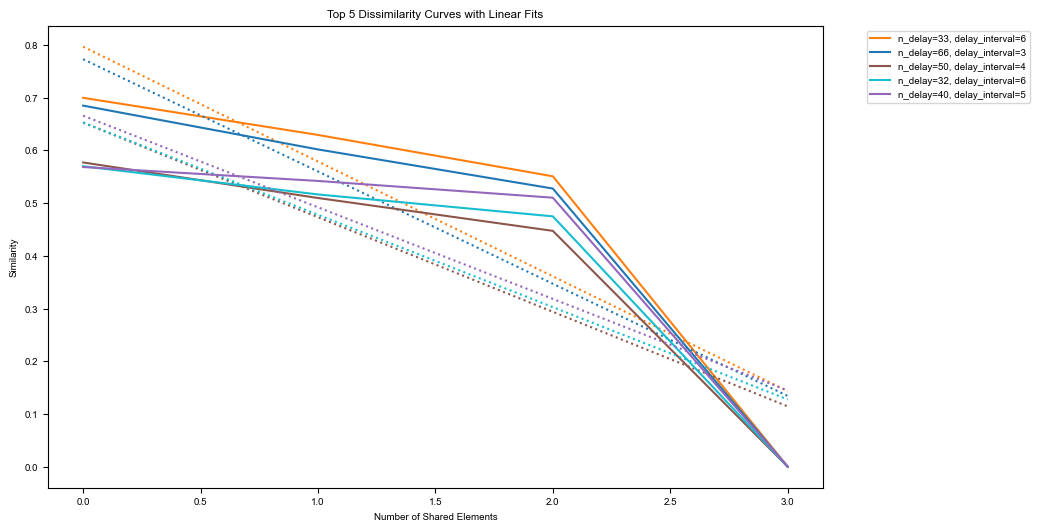

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv") and file.endswith("ordered.csv"):
        # split the name of the file to get the parameters
        parameters = file.split("_")
        n_delay = int(parameters[1])
        delay_interval = int(parameters[2].split(".")[0])
        df = pd.read_csv(os.path.join(path, file))
        df["n_delay"] = n_delay
        df["delay_interval"] = delay_interval
        data.append(df)
data = pd.concat(data)
data.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = data.dropna()

# Group data
data = (
    data_all.groupby(["n_delay", "delay_interval", "number_of_shared_elements"])[
        "similarity"
    ]
    .mean()
    .reset_index()
)
groups = data.groupby(["n_delay", "delay_interval"])

# Prepare a dataframe to store the results
results = []

# Iterate over each group of parameters
for (n_delay, delay_interval), group in groups:
    # Fit a linear model
    slope, intercept, r_value, p_value, std_err = linregress(
        group["number_of_shared_elements"], group["similarity"]
    )

    # Calculate the gap
    similarity_0 = group[group["number_of_shared_elements"] == 0]["similarity"].values[
        0
    ]
    similarity_3 = group[group["number_of_shared_elements"] == 3]["similarity"].values[
        0
    ]
    gap = similarity_0 - similarity_3

    # Check if the curve goes to 0 at shared elements = 3
    goes_to_zero = np.isclose(similarity_3, 0)

    # Store the results
    results.append(
        {
            "n_delay": n_delay,
            "delay_interval": delay_interval,
            "slope": slope,
            "intercept": intercept,
            "r_value": r_value,
            "gap": gap,
            "goes_to_zero": goes_to_zero,
        }
    )

results_df = pd.DataFrame(results)

# Filter out curves that do not go to zero at shared elements = 3
results_df = results_df[results_df["goes_to_zero"]]

# Select the best parameters
best_params = results_df.sort_values(
    by=["gap", "r_value"], ascending=[False, False]
).head(5)

# Plot the best 5 curves with their linear fit
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10")

for i, row in best_params.iterrows():
    n_delay = row["n_delay"]
    delay_interval = row["delay_interval"]
    group = groups.get_group((n_delay, delay_interval))
    plt.plot(
        group["number_of_shared_elements"],
        group["similarity"],
        label=f"n_delay={n_delay}, delay_interval={delay_interval}",
        color=colors(i % 10),
    )

    # Plot the linear fit as a dotted line
    fit_x = np.array([0, 1, 2, 3])
    fit_y = row["slope"] * fit_x + row["intercept"]
    plt.plot(fit_x, fit_y, color=colors(i % 10), linestyle="dotted")

plt.xlabel("Number of Shared Elements")
plt.ylabel("Similarity")
plt.title("Top 5 Dissimilarity Curves with Linear Fits")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [14]:
best_params

,n_delay,delay_interval,slope,intercept,r_value,gap,goes_to_zero
51,33,6,-0.217698,0.796378,-0.880846,0.699519,True
80,66,3,-0.212839,0.772718,-0.889074,0.684736,True
75,50,4,-0.179306,0.652384,-0.886758,0.576922,True
49,32,6,-0.175084,0.652826,-0.859358,0.569767,True
64,40,5,-0.173665,0.665573,-0.827019,0.568301,True


## Without order

In [15]:
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        if not file.endswith("ordered.csv"):
            # split the name of the file to get the parameters
            parameters = file.split("_")
            n_delay = int(parameters[1])
            delay_interval = int(parameters[2].split(".")[0])
            df = pd.read_csv(os.path.join(path, file))
            df["n_delay"] = n_delay
            df["delay_interval"] = delay_interval
            data.append(df)
data = pd.concat(data)
data.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = (
    data.dropna()
)  # plot on a single plot the Median similarity vs Number of shared elements for pair  (n_delay, delay_interval)
data = (
    data_all.groupby(["n_delay", "delay_interval", "number_of_shared_elements"])[
        "similarity"
    ]
    .mean()
    .reset_index()
)
groups = data.groupby(["n_delay", "delay_interval"])

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Assuming 'data' and 'groups' are already defined as per your script

# Convert pandas DataFrame to Bokeh's ColumnDataSource
source = ColumnDataSource(data)

# Output the plot directly in the notebook
output_notebook()

# Create a figure
p = figure(
    width=800,
    height=600,
    title="Influence of n_delay on Median similarity vs Number of shared elements",
    x_axis_label="Number of shared elements",
    y_axis_label="Median similarity",
)

# Generate a consistent color scale for n_delay and delay_interval pairs
base_colors_n_delay = list(mcolors.TABLEAU_COLORS.values())
color_map_n_delay = {}

# Plotting
for i, (n_delay, delay_interval) in enumerate(
    data[["n_delay", "delay_interval"]].drop_duplicates().values
):
    color = mcolors.rgb2hex(base_colors_n_delay[i % len(base_colors_n_delay)])
    color_map_n_delay[(n_delay, delay_interval)] = color

for (n_delay, delay_interval), group in groups:
    color = color_map_n_delay[(n_delay, delay_interval)]
    p.line(
        x="number_of_shared_elements",
        y="similarity",
        source=group,
        line_width=2,
        line_color=color,
        alpha=0.8,
        legend_label=f"n_delay={n_delay}, delay_interval={delay_interval}",
    )

# Adding hover tool
hover = HoverTool()
hover.tooltips = [("Parameters", "@n_delay, @delay_interval")]
p.add_tools(hover)

# Remove the legend
p.legend.visible = False

# Show plot inline in notebook
show(p)

Loading BokehJS ...

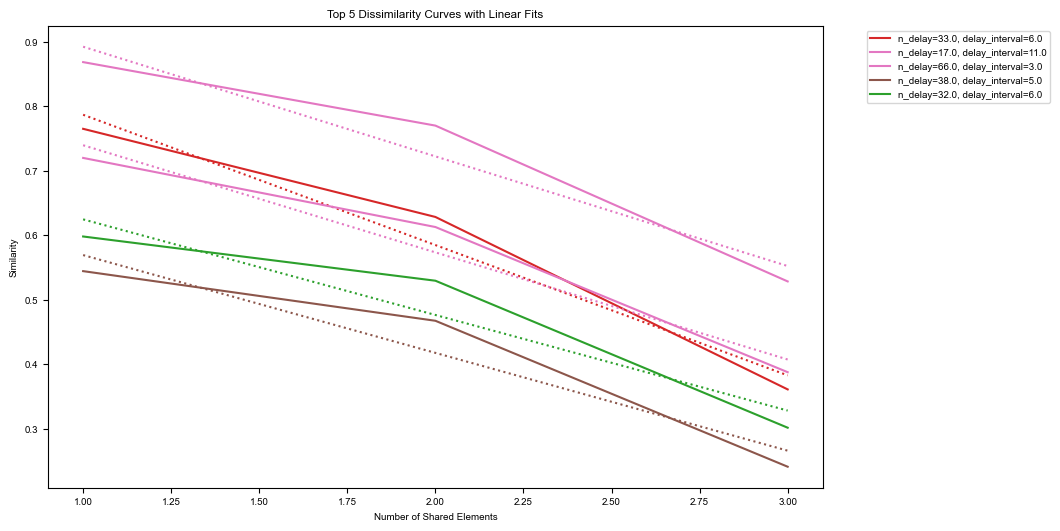

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load data
path = "../data/dsa_results"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv") and not file.endswith("ordered.csv"):
        # split the name of the file to get the parameters
        parameters = file.split("_")
        n_delay = int(parameters[1])
        delay_interval = int(parameters[2].split(".")[0])
        df = pd.read_csv(os.path.join(path, file))
        df["n_delay"] = n_delay
        df["delay_interval"] = delay_interval
        data.append(df)
data = pd.concat(data)
data.rename(
    columns={"number of shared elements": "number_of_shared_elements"}, inplace=True
)
data_all = data.dropna()

# Group data
data = (
    data_all.groupby(["n_delay", "delay_interval", "number_of_shared_elements"])[
        "similarity"
    ]
    .mean()
    .reset_index()
)
groups = data.groupby(["n_delay", "delay_interval"])

# Prepare a dataframe to store the results
results = []

# Iterate over each group of parameters
for (n_delay, delay_interval), group in groups:
    # Fit a linear model
    slope, intercept, r_value, p_value, std_err = linregress(
        group["number_of_shared_elements"], group["similarity"]
    )

    # Calculate the gap
    similarity_0 = group[group["number_of_shared_elements"] == 1]["similarity"].values[
        0
    ]
    similarity_3 = group[group["number_of_shared_elements"] == 3]["similarity"].values[
        0
    ]
    gap = similarity_0 - similarity_3

    # Store the results
    results.append(
        {
            "n_delay": n_delay,
            "delay_interval": delay_interval,
            "slope": slope,
            "intercept": intercept,
            "r_value": r_value,
            "gap": gap,
        }
    )

results_df = pd.DataFrame(results)

# Select the best parameters
best_params = results_df.sort_values(
    by=["gap", "r_value"], ascending=[False, False]
).head(5)

# Plot the best 5 curves with their linear fit
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10")

for i, row in best_params.iterrows():
    n_delay = row["n_delay"]
    delay_interval = row["delay_interval"]
    group = groups.get_group((n_delay, delay_interval))
    plt.plot(
        group["number_of_shared_elements"],
        group["similarity"],
        label=f"n_delay={n_delay}, delay_interval={delay_interval}",
        color=colors(i % 10),
    )

    # Plot the linear fit as a dotted line
    fit_x = np.array([1, 2, 3])
    fit_y = row["slope"] * fit_x + row["intercept"]
    plt.plot(fit_x, fit_y, color=colors(i % 10), linestyle="dotted")

plt.xlabel("Number of Shared Elements")
plt.ylabel("Similarity")
plt.title("Top 5 Dissimilarity Curves with Linear Fits")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [18]:
best_params

,n_delay,delay_interval,slope,intercept,r_value,gap
13,33,6,-0.202009,0.988496,-0.982997,0.404018
6,17,11,-0.170011,1.061990,-0.971716,0.340022
26,66,3,-0.166097,0.905334,-0.979636,0.332194
15,38,5,-0.151619,0.720565,-0.961887,0.303239
12,32,6,-0.148231,0.772552,-0.955080,0.296462
